# **DCGAN Tutorial**

### We will train a generative adversarial network (GAN), called DCGAN.
A DCGAN is a direct extension of the GAN, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. It was first described by Radford et. al. in the paper Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution. The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activations. The input is a latent vector,
z, that is drawn from a standard normal distribution and the output is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image.

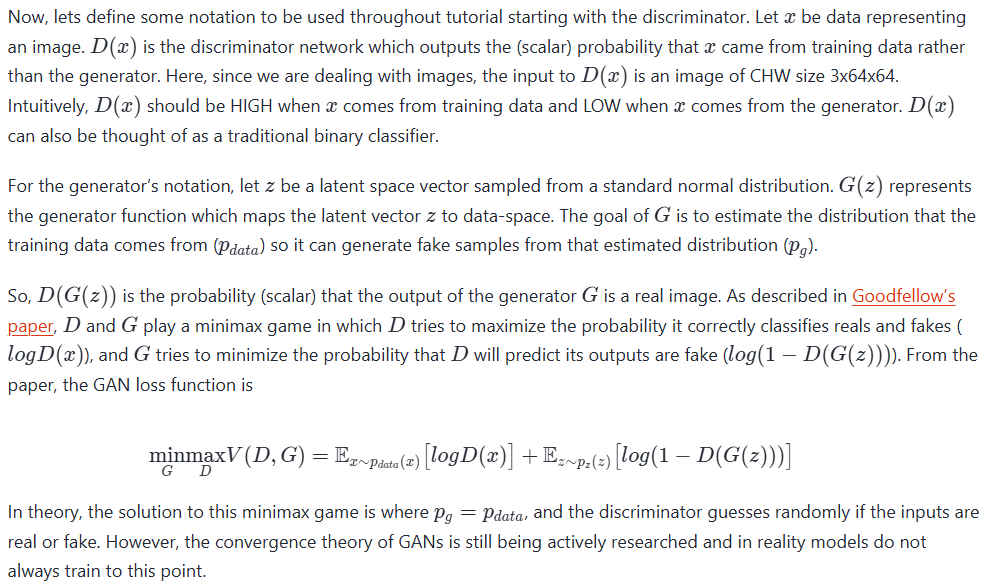

## **Installing the libraries**

In [2]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
#manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


## **Connect to Google Colab**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Inputs**

* dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section.

* workers - the number of worker threads for loading the data with the DataLoader.

* batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128.

* image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details.

* nc - number of color channels in the input images. For color images this is 3.

* nz - length of latent vector.

* ngf - relates to the depth of feature maps carried through the generator.

* ndf - sets the depth of feature maps propagated through the discriminator.

* num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer.

* lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002.

* beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5.

* ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs.

In [6]:
# Root directory for dataset
import zipfile

dataroot = "/content/drive/MyDrive/data/img_align_celeba.zip"
with zipfile.ZipFile(dataroot, 'r') as zip_ref:
  zip_ref.extractall()

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

## **Data (Have to create custom DataSet Function)**

In [9]:
import os
import zipfile

# Посмотрим содержимое текущей директории
print("Содержимое текущей директории:")
print(os.listdir('.'))

# Если есть подпапки, посмотрим их тоже
for item in os.listdir('.'):
    if os.path.isdir(item):
        print(f"\nСодержимое папки {item}:")
        print(os.listdir(item))

Содержимое текущей директории:
['.config', 'drive', 'img_align_celeba', 'sample_data']

Содержимое папки .config:
['.last_survey_prompt.yaml', '.last_update_check.json', 'active_config', 'config_sentinel', 'configurations', 'logs', 'hidden_gcloud_config_universe_descriptor_data_cache_configs.db', '.last_opt_in_prompt.yaml', 'default_configs.db', 'gce']

Содержимое папки drive:
['MyDrive', 'Othercomputers', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']

Содержимое папки img_align_celeba:
['044068.jpg', '032247.jpg', '049156.jpg', '010576.jpg', '185523.jpg', '084825.jpg', '149971.jpg', '114621.jpg', '025644.jpg', '024294.jpg', '171613.jpg', '111740.jpg', '058360.jpg', '070174.jpg', '073972.jpg', '178670.jpg', '008996.jpg', '159074.jpg', '037078.jpg', '132654.jpg', '064878.jpg', '144407.jpg', '023856.jpg', '122274.jpg', '066795.jpg', '135474.jpg', '039570.jpg', '099671.jpg', '067666.jpg', '001570.jpg', '178989.jpg', '067125.jpg', '022674.jpg', '167982.jpg', '126038.jpg', '005718.jp

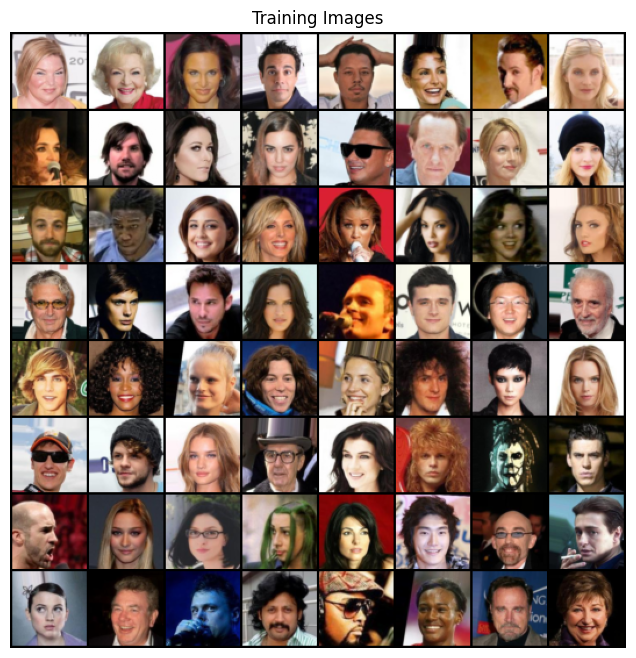

In [12]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
from torch.utils.data import Dataset
from PIL import Image
import glob

class FlatImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.jpg')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0  # фиктивный label

dataset = FlatImageDataset(root_dir='./img_align_celeba',
                          transform=transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## **Implementation**

### **Weight Initialization**

### All model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### **Generator**

The generator,
G
, is designed to map the latent space vector (
z
) to data-space. Since our data are images, converting
z
 to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of
[−1,1]
. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

### **Generator structure**

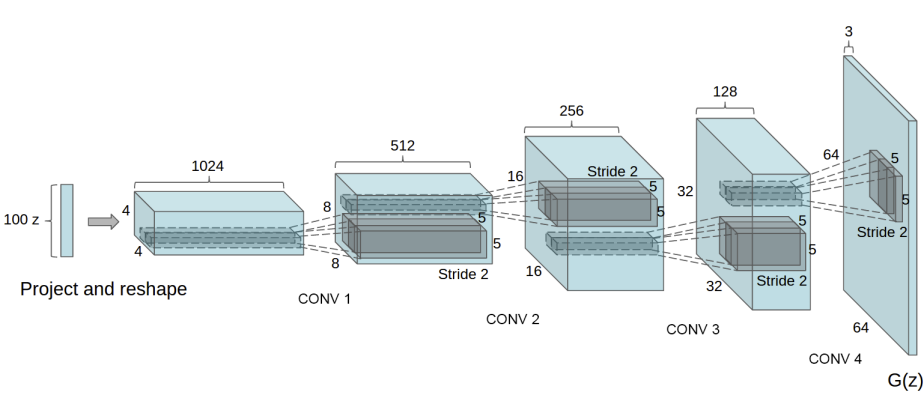

Notice, how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

In [14]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### **Discriminator**

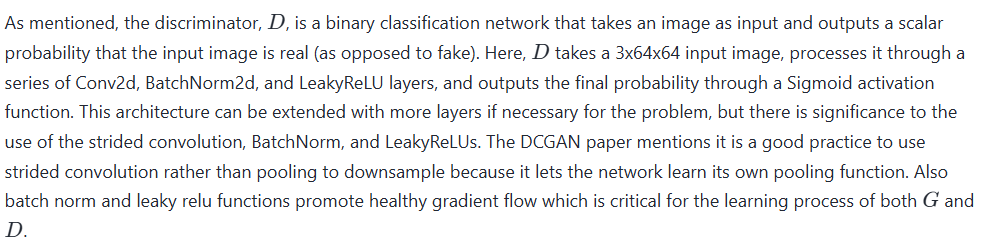

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### **Loss Functions and Optimizers**

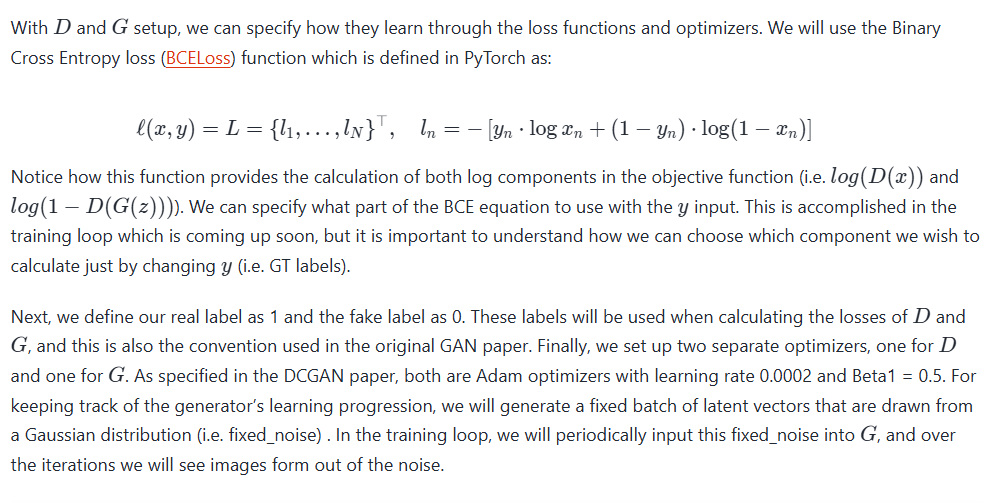

In [18]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## **Training**

### **Part 1 - Train the Discriminator**

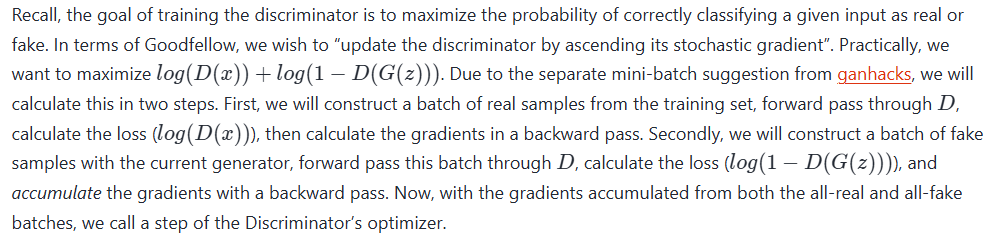

### **Part 2 - Train the Generator**

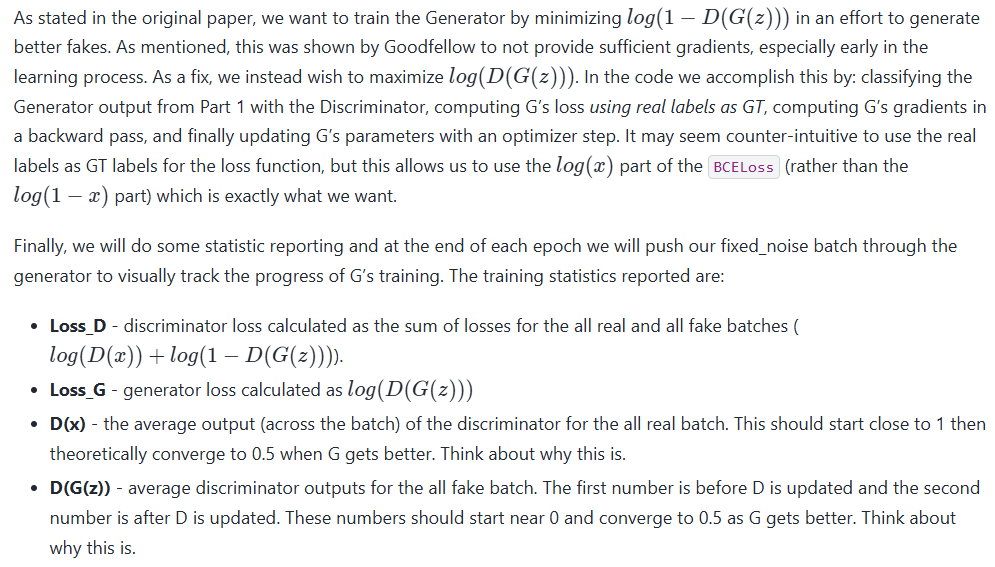

In [19]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 1.4714	Loss_G: 5.6356	D(x): 0.6227	D(G(z)): 0.5603 / 0.0049
[0/5][50/1583]	Loss_D: 0.1385	Loss_G: 11.5909	D(x): 0.9214	D(G(z)): 0.0002 / 0.0000
[0/5][100/1583]	Loss_D: 0.3542	Loss_G: 5.2468	D(x): 0.8166	D(G(z)): 0.0418 / 0.0102
[0/5][150/1583]	Loss_D: 0.1519	Loss_G: 3.5522	D(x): 0.9242	D(G(z)): 0.0552 / 0.0507
[0/5][200/1583]	Loss_D: 0.3201	Loss_G: 3.1169	D(x): 0.8672	D(G(z)): 0.1102 / 0.0738
[0/5][250/1583]	Loss_D: 0.4419	Loss_G: 4.8716	D(x): 0.9072	D(G(z)): 0.2361 / 0.0138
[0/5][300/1583]	Loss_D: 0.4027	Loss_G: 6.1764	D(x): 0.9601	D(G(z)): 0.2641 / 0.0039
[0/5][350/1583]	Loss_D: 0.7867	Loss_G: 3.1751	D(x): 0.5889	D(G(z)): 0.0269 / 0.0717
[0/5][400/1583]	Loss_D: 0.5990	Loss_G: 4.6564	D(x): 0.7443	D(G(z)): 0.1635 / 0.0172
[0/5][450/1583]	Loss_D: 0.7936	Loss_G: 5.1106	D(x): 0.9200	D(G(z)): 0.4396 / 0.0173
[0/5][500/1583]	Loss_D: 0.5103	Loss_G: 7.1860	D(x): 0.9070	D(G(z)): 0.2791 / 0.0016
[0/5][550/1583]	Loss_D: 0.5777	Loss_G: 5.3220	D(x): 

## **Results**

### **Loss versus training iteration**

### Below is a plot of D & G’s losses versus training iterations.

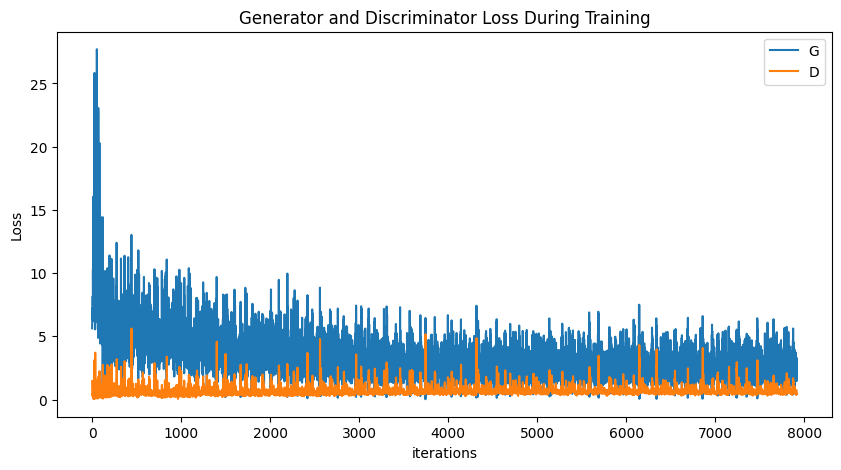

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Visualization of G’s progression**

### Remember how we saved the generator’s output on the fixed_noise batch after every epoch of training. Now, we can visualize the training progression of G with an animation. Press the play button to start the animation.

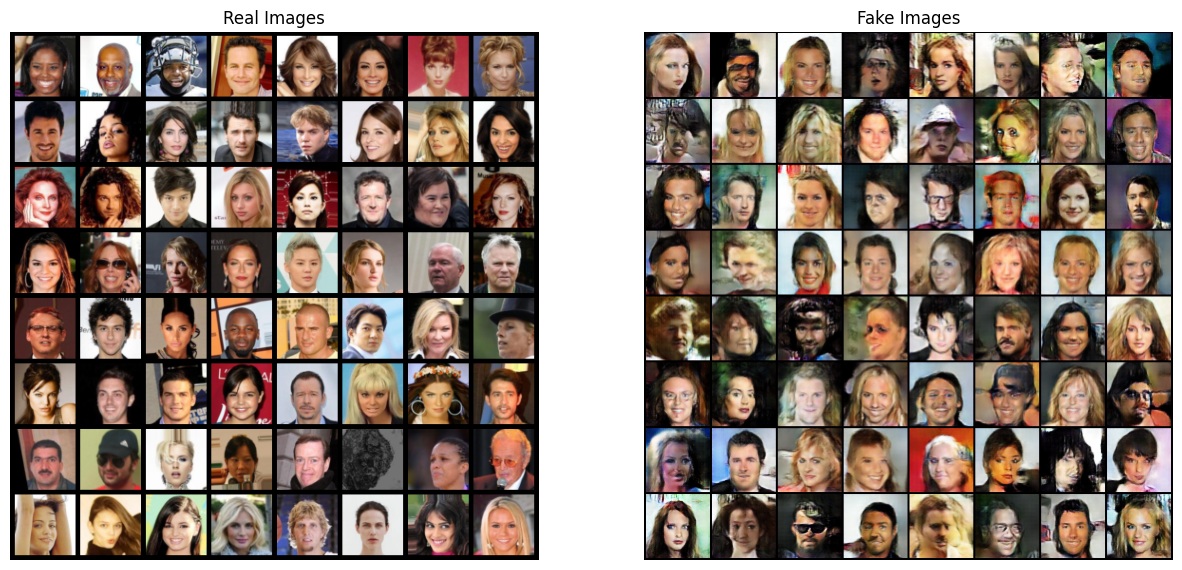

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()